# Tutorial 1.6: Sensitivity analysis

- **Authors**: Xiaoyu Xie
- **Contact**: xiaoyuxie2020@u.northwestern.edu

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiaoyuxie-vico/PyDimension-Book/blob/main/examples/sensitive_analysis.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xiaoyuxie-vico/PyDimension-Book/HEAD)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from SALib.analyze import sobol
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from SALib.sample import saltelli
import seaborn as sns

%matplotlib inline
# plt.rcParams["font.family"] = 'Arial'

In [2]:
# # please uncomment these two lines, if you run this code in Colab
# !git clone https://github.com/xiaoyuxie-vico/PyDimension-Book
# %cd PyDimension-Book/examples

## Helper functions

In [3]:
def parse_data(df, para_list, output='e*'):
    '''Parse the input and output parameters'''
    X = df[para_list].to_numpy()
    y = df[output].to_numpy()
    return X, y

def calculate_bounds(df, para_list):
    '''Calculate lower and upper bounds for each parameter'''
    bounds = []
    for var_name in para_list:
        bounds.append([df[var_name].min(), df[var_name].max()])
    return bounds

def train_model(X, y, coef_pi, deg):
    '''Build a predictive model with polynomial function'''
    # build features
    pi1 = np.prod(np.power(X, coef_pi.reshape(-1,)), axis=1).reshape(-1, 1)
    poly = PolynomialFeatures(deg)
    pi1_poly = poly.fit_transform(pi1)
    
    # fit
    model = LinearRegression(fit_intercept=False)
    model.fit(pi1_poly, y)
    model.score(pi1_poly, y)
    return model, poly

def SA(para_list, coef_pi, bounds, model, poly, sample_num=2**10):
    '''Sensitivity analysis'''
    problem = {'num_vars': len(para_list), 'names': para_list, 'bounds': bounds}

    # Generate samples
    X_sampled = saltelli.sample(problem, sample_num, calc_second_order=True)
    pi1_sampled = np.prod(np.power(X_sampled, coef_pi.reshape(-1,)), axis=1).reshape(-1, 1)
    pi1_sampled_poly = poly.transform(pi1_sampled)
    Y_sampled = model.predict(pi1_sampled_poly).reshape(-1,)
    print(Y_sampled.shape)

    # Perform analysis
    Si = sobol.analyze(problem, Y_sampled, print_to_console=True)
    
    return Si

def plot(Si, xtick_labels):
    '''Visualization'''
    total_Si, first_Si, second_Si = Si.to_df()
    
    total_Si['Type'] = ['Sobol total'] * total_Si.shape[0]
    total_Si = total_Si.rename(columns={'ST': 'Sensitivity', 'ST_conf': 'conf'})
    total_Si.index.name = 'Variable'
    total_Si.reset_index(inplace=True)

    first_Si['Type'] = ['Sobol 1st order'] * first_Si.shape[0]
    first_Si = first_Si.rename(columns={'S1': 'Sensitivity', 'S1_conf': 'conf'})
    first_Si.index.name = 'Variable'
    first_Si.reset_index(inplace=True)
    
    res_df = pd.concat([first_Si, total_Si]).reset_index(drop=False)
    # res_df = res_df.reindex(combined_df_index)
    
    fig = plt.figure()
    ax = sns.barplot(data=res_df, x='Variable', y='Sensitivity', hue='Type')
    ax.set_xticklabels(xtick_labels)
    ax.legend(fontsize=14)
    ax.set_xlabel('Variable', fontsize=16)
    ax.set_ylabel('Sensitivity', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=13)
    plt.tight_layout()


## Load keyhole dataset

In [4]:
# load data
df = pd.read_csv('../dataset/dataset_keyhole.csv')
df.describe()

,etaP,Vs,r0,alpha,rho,cp,Tv-T0,Lv,Tl-T0,Lm,e,Ke,e*
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,9.000000e+01,90.000000,90.000000,90.000000,90.000000,90.000000
mean,143.036444,0.733889,0.000053,0.000013,3949.633333,872.222222,3130.533333,9.197967e+06,1480.044444,296511.111111,0.000173,9.981230,3.520206
std,85.162496,0.267933,0.000010,0.000008,997.040085,117.939022,275.287641,9.413036e+05,342.642865,33657.309487,0.000129,7.220693,2.799219
min,31.400000,0.300000,0.000044,0.000005,2415.000000,790.000000,2499.000000,6.336000e+06,622.000000,260000.000000,0.000015,1.545937,0.208731
25%,73.825000,0.600000,0.000048,0.000010,3920.000000,830.000000,3267.000000,9.255000e+06,1630.000000,286000.000000,0.000071,4.197719,1.300126
50%,120.160000,0.700000,0.000048,0.000010,3920.000000,830.000000,3267.000000,9.255000e+06,1630.000000,286000.000000,0.000146,7.947395,2.925625
75%,192.895000,1.000000,0.000066,0.000010,3920.000000,830.000000,3267.000000,9.255000e+06,1630.000000,286000.000000,0.000252,14.359714,5.232955
max,342.600000,1.200000,0.000070,0.000032,6881.000000,1170.000000,3267.000000,1.053000e+07,1630.000000,380000.000000,0.000562,37.772286,12.772727


## Analysis for Ke

In [5]:
# config
para_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0']
coef_pi = np.array([1, -0.5, -1.5, -0.5, -1, -1, -1])  # for Ke
deg = 3

# choose parameters
X, y = parse_data(df, para_list)

# calculate bounds
bounds = calculate_bounds(df, para_list)

# train mdoel
model, poly = train_model(X, y, coef_pi, deg)

# calculate sensitivity
Si = SA(para_list, coef_pi, bounds, model, poly)

/tmp/ipykernel_13504/3367990274.py:32: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_sampled = saltelli.sample(problem, sample_num, calc_second_order=True)


(16384,)
             ST   ST_conf
etaP   0.468911  0.056928
Vs     0.075444  0.009698
r0     0.086941  0.012552
alpha  0.137722  0.016489
rho    0.194494  0.022837
cp     0.026777  0.003598
Tl-T0  0.160593  0.020186
             S1   S1_conf
etaP   0.379400  0.055575
Vs     0.058095  0.027235
r0     0.061965  0.025987
alpha  0.110631  0.031598
rho    0.144342  0.048481
cp     0.018855  0.014861
Tl-T0  0.128264  0.035198
                      S2   S2_conf
(etaP, Vs)      0.008929  0.067780
(etaP, r0)      0.014155  0.063702
(etaP, alpha)   0.010734  0.071605
(etaP, rho)     0.042107  0.080435
(etaP, cp)      0.003964  0.064910
(etaP, Tl-T0)   0.018733  0.075123
(Vs, r0)       -0.003869  0.042091
(Vs, alpha)    -0.006055  0.041836
(Vs, rho)       0.000813  0.042304
(Vs, cp)       -0.007282  0.037941
(Vs, Tl-T0)    -0.000395  0.044344
(r0, alpha)     0.003093  0.046061
(r0, rho)      -0.001922  0.041634
(r0, cp)        0.002067  0.040927
(r0, Tl-T0)     0.001900  0.045898
(alpha, rho)   

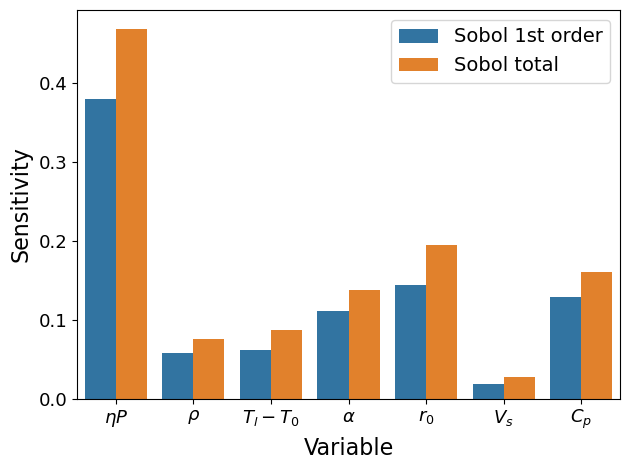

In [6]:
xtick_labels = [r'$\eta P$', r'$\rho$', r'$T_l-T_0$', r'$\alpha$', r'$r_0$', r'$V_s$', r'$C_p$']
# sort the sensitivity from high to low
# combined_df_index = [0, 4, 6, 3, 2, 1, 5, 0+7, 4+7, 6+7, 3+7, 2+7, 1+7, 5+7] 
plot(Si, xtick_labels)

## Add one more parameter $T_v-T_l$

In [7]:
# config
para_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0', 'Tv-T0']
coef_pi = np.array([1, -0.5, -1.5, -0.5, -1, -1, -0.75, -0.25])  # for table 3, 2nd row
deg = 3

# choose parameters
X, y = parse_data(df, para_list)

# calculate bounds
bounds = calculate_bounds(df, para_list)

# train mdoel
model, poly = train_model(X, y, coef_pi, deg)

# calculate sensitivity
Si = SA(para_list, coef_pi, bounds, model, poly)

/tmp/ipykernel_13504/3367990274.py:32: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_sampled = saltelli.sample(problem, sample_num, calc_second_order=True)


(18432,)
             ST   ST_conf
etaP   0.435631  0.134623
Vs     0.102755  0.021786
r0     0.101415  0.031282
alpha  0.216431  0.056151
rho    0.243284  0.091602
cp     0.029825  0.006825
Tl-T0  0.154469  0.084950
Tv-T0  0.001798  0.001092
             S1   S1_conf
etaP   0.293056  0.077243
Vs     0.058431  0.028659
r0     0.060356  0.031793
alpha  0.111009  0.041541
rho    0.143368  0.047292
cp     0.017399  0.011495
Tl-T0  0.059561  0.027110
Tv-T0  0.000351  0.003124
                      S2   S2_conf
(etaP, Vs)      0.001401  0.065627
(etaP, r0)     -0.004557  0.060997
(etaP, alpha)   0.022270  0.071110
(etaP, rho)     0.009413  0.072088
(etaP, cp)     -0.011741  0.059219
(etaP, Tl-T0)   0.010808  0.076470
(etaP, Tv-T0)  -0.008894  0.062713
(Vs, r0)       -0.008851  0.053176
(Vs, alpha)    -0.008343  0.065172
(Vs, rho)      -0.010061  0.057539
(Vs, cp)       -0.009823  0.045981
(Vs, Tl-T0)    -0.006326  0.058689
(Vs, Tv-T0)    -0.009010  0.046571
(r0, alpha)    -0.013241  0.05639

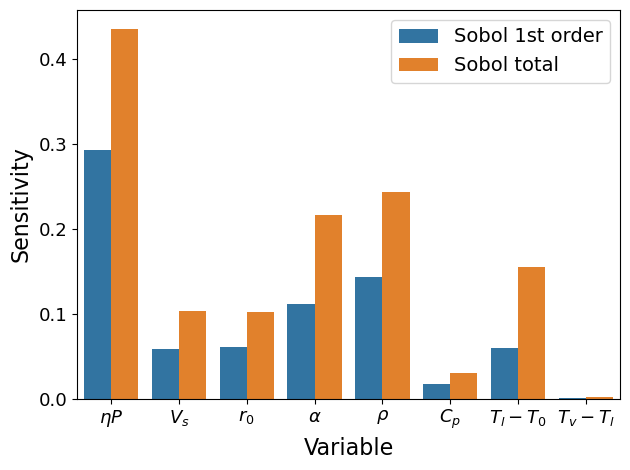

In [8]:
xtick_labels = [r'$\eta P$', r'$V_s$', r'$r_0$', r'$\alpha$', r'$\rho$',
                    r'$C_p$', r'$T_l-T_0$', r'$T_v-T_l$']
plot(Si, xtick_labels)

## Add one more parameter $L_m$

In [9]:
# config
para_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0', 'Lm']
coef_pi = np.array([1, -0.5, -1.5, -0.5, -1, -0.75, -0.75, -0.25])  # for table 4, 3rd row
deg = 3

# choose parameters
X, y = parse_data(df, para_list)

# calculate bounds
bounds = calculate_bounds(df, para_list)

# train mdoel
model, poly = train_model(X, y, coef_pi, deg)

# calculate sensitivity
Si = SA(para_list, coef_pi, bounds, model, poly)

/tmp/ipykernel_13504/3367990274.py:32: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_sampled = saltelli.sample(problem, sample_num, calc_second_order=True)


(18432,)


             ST   ST_conf
etaP   0.407922  0.180610
Vs     0.114861  0.041372
r0     0.109062  0.049810
alpha  0.253861  0.115523
rho    0.295320  0.216713
cp     0.018771  0.008362
Tl-T0  0.216055  0.212208
Lm     0.005355  0.004654
             S1   S1_conf
etaP   0.246249  0.092355
Vs     0.053234  0.026338
r0     0.051079  0.030485
alpha  0.101483  0.046561
rho    0.127977  0.058670
cp     0.008455  0.008518
Tl-T0  0.051638  0.028429
Lm     0.000703  0.003790
                      S2   S2_conf
(etaP, Vs)     -0.001122  0.056589
(etaP, r0)     -0.008193  0.054476
(etaP, alpha)   0.019447  0.076453
(etaP, rho)     0.006793  0.067423
(etaP, cp)     -0.014905  0.057506
(etaP, Tl-T0)   0.011559  0.081713
(etaP, Lm)     -0.010896  0.059814
(Vs, r0)       -0.011737  0.052146
(Vs, alpha)    -0.012059  0.071268
(Vs, rho)      -0.014467  0.058041
(Vs, cp)       -0.012331  0.047543
(Vs, Tl-T0)    -0.009250  0.061771
(Vs, Lm)       -0.011251  0.047606
(r0, alpha)    -0.008149  0.055715
(r0, rh

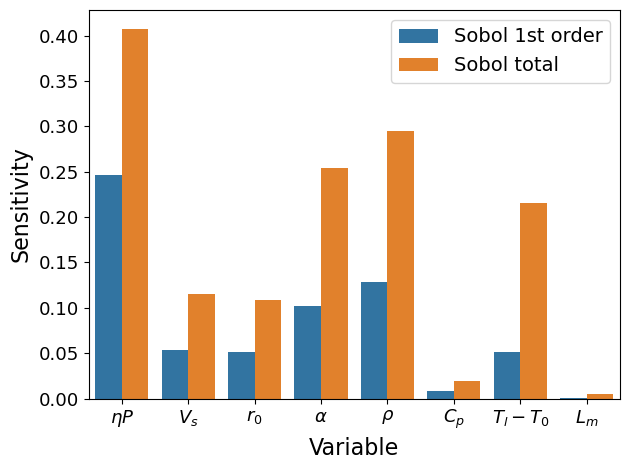

In [10]:
xtick_labels = [r'$\eta P$', r'$V_s$', r'$r_0$', r'$\alpha$', r'$\rho$',
                    r'$C_p$', r'$T_l-T_0$', r'$L_m$']
plot(Si, xtick_labels)